# Correct images

In this notebook we show how a typhoon sequence can be cleaned. By cleaning we understand mainly two components:
* **Detecting and correcting damaged sequences**: Some frames have corrupted pixels. To solve this, different approaches can be followed.
* **Filling image temporal gaps**: This, however, should always be done within a tolerance range. This means, for instance, that gaps of 20 frames might not be wise to fill as resulting synthetic frames might be very blurry or difuse.

First, we load a sequence.

In [2]:
import sys
sys.path.insert(0, '..')
from pyphoon.io import read_typhoonlist_h5
# Read sequence
typhoon_sequence = read_typhoonlist_h5('../sampledata/197906.h5')

/Users/lucasrodes/NII/pyphoon/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let us check the shape of `typhoon_sequence`, which gives us: shape frame array, shape images ids array, shape best data array, best ids array.

In [3]:
typhoon_sequence.shape

((73, 512, 512), (73, 1), (217, 22), (217, 1))

Now time to correct the typhoon list. We achieve this by using the method `fix_sequence` provided by `pyphoon` 
under the module `pyphoon.preprocessing.clean`. This step can take few seconds.

In [33]:
from pyphoon.preprocessing.clean import fix_sequence
# Obtained cleaned sequence
typhoon_sequence_new = fix_sequence(typhoon_sequence, gap_filling=False, display=False)

In [34]:
typhoon_sequence_new = fix_sequence(typhoon_sequence_new, gap_filling=True, display=False)

After filling the temporal gaps, we should see an increase in the size of the arrays of image frames and image frame ids. In our case, as all the temporal gaps are within the tolerance margin, the number of image frames and best data samples is equal.

In [5]:
typhoon_sequence_new.shape

((217, 512, 512), (217, 1), (217, 22), (217, 1))

Finally, we may want to visualize both sequences, before and after applying `fix_sequence`. In the title of the images three parameters are displayed: the *typhoon id*, the *frame index* and a *flag* determining whether the image was kept as the original (0), corrected (1) or synthetised (2).

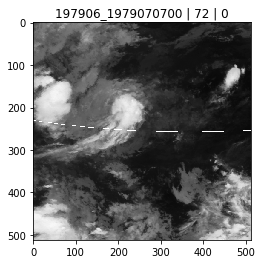

In [5]:
from pyphoon.utils import DisplaySequence
from IPython.display import HTML

HTML(DisplaySequence(
    typhoon_sequence=typhoon_sequence,
    interval=100
).run_html())

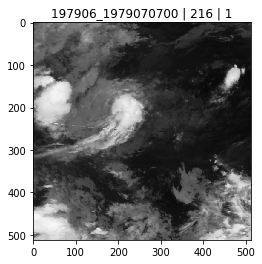

In [6]:
HTML(DisplaySequence(
    typhoon_sequence=typhoon_sequence_new,
    interval=100
).run_html())

After correcting a typhoon sequence, we might want to store the new version. 

In [ ]:
typhoon_sequence_new.save_as_h5('../sampledata/197906_corrected.h5', compression='gzip')

### Remark
If synthetic image frames have been generated (i.e. `gap_filling` variable was set to True) or frame regions have been corrected, the size of the new generated file will be considerably larger (in particular approach if first has been done). This is due to the fact that the new generated image contains more different pixel values. It seems that pixel values from original real frames are only allowed to take a certain set of values. Therefore, to mitigate this issue, synthetic image frames should only contain pixel values of that set. Also note that our experiments showed that nearest value brut force search may increase interpolation process by factor of 900. 